<a href="https://colab.research.google.com/github/dowrave/RoadToImageSeg_GAN/blob/main/220511_VariationalAutoEncoder(VAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[텐서플로우 튜토리얼](https://www.tensorflow.org/tutorials/generative/cvae?hl=ko)
### VAE
- AE의 확률론적 형태 : 입력을 잠재 벡터에 매핑하지 않고 <b>확률 분포의 매개변수에 매핑</b>한다.
- 연속적이고 구조화된 잠재 공간을 생성하기 때문에 이미지 생성에 유리하다.


In [32]:
!pip install tensorflow-probability

# gif 생성을 위한 것들
!pip install imageio
!pip install git+https://github.com/tensorflow/docs 

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-q388fwbh
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-q388fwbh


In [33]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import layers

In [34]:
# MNIST 데이터셋 로드
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [35]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [36]:
train_size = 60000
batch_size = 32
test_size = 10000

In [37]:
# tf.data로 데이터 배치 & 셔플 처리
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

## 네트워크 구성
- 인코더 : q(z|x)를 정의 : output이 분포(잠재 표현 z)인 것만 신경쓰자
- 디코더 : q(z|x)를 받아 p(x|z)를 정의함

## VAE의 포인트
- 역전파 과정에서 무작위 노드 분포가 있다면 병목 현상이 발생함
- 이를 해결하기 위해 재매개변수화 트릭을 사용함.
- 기억해보자 : 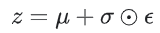
- 즉 평균과 표준편차 항을 따로 빼내고, epsilon을 무작위 노이즈로 생각하는 것. epsilon 값은 표준 정규 분포에서 생성된다.
- 이를 통해 mu와 sigma를 통해 graident를 역전파하고, epsilon으로 무질서도를 유지할 수 있다.

In [38]:
class CVAE(tf.keras.Model):
  '''Convolutonal Variational Auto Encoder'''

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
                                        layers.InputLayer(input_shape = (28, 28, 1)),
                                        layers.Conv2D(
                                            filters = 32, kernel_size = 3, strides = (2, 2), activation = 'relu',
                                        ),
                                        layers.Conv2D(filters=64, kernel_size = 3, strides = (2, 2), activation = 'relu'),
                                        layers.Flatten(),
                                        # 마지막 출력층에 활성화 함수를 적용하지 않음!
                                        layers.Dense(latent_dim + latent_dim),
    ])

    self.decoder = tf.keras.Sequential([
                                        layers.InputLayer(input_shape = (latent_dim, )),
                                        layers.Dense(units = 7*7*32, activation = tf.nn.relu),
                                        tf.keras.layers.Reshape(target_shape = (7, 7, 32)),
                                        tf.keras.layers.Conv2DTranspose(
                                            filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'
                                        ),
                                        tf.keras.layers.Conv2DTranspose(
                                            filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'
                                        ),
                                        # 마지막 층에 활성화 함수를 적용하지 않음!
                                        tf.keras.layers.Conv2DTranspose(
                                            filters = 1, kernel_size = 3, strides = 1, padding = 'same'
                                        )
    ])

  @tf.function
  def sample(self, eps = None):
    if eps is None:
      eps = tf.random.normal(shape = (100, self.latent_dim))
    return self.decode(eps, apply_sigmoid = True)
  
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits = 2, axis = 1)
    return mean, logvar
  
  def reparametrize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
  
  def decode(self, z, apply_sigmoid = False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


### 손실 함수와 옵티마이저 정의하기
- 한계 우도에 대한 ELBO를 최대화 하여 훈련한다.
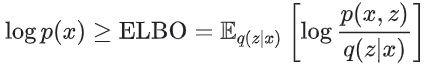
- 이 예상에 대한 단일 샘플 몬테카를로 추정값을 최적화한다.
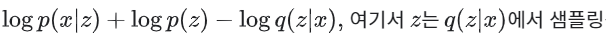

In [48]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis = 1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis = raxis
    )

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparametrize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits = x_logit, labels = x)
  logpx_z = -tf.reduce_sum(cross_ent, axis = [1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 훈련

In [40]:
epochs = 10

# 시각화를 위한 차원 지정
latent_dim = 2

num_examples_to_generate = 16

# 초기 벡터는 랜덤하게 지정
random_vector_for_generation = tf.random.normal(
    shape = [num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [44]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparametrize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize = (4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap = 'gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [42]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch : 10, Test set EBLO : -156.5906524658203, time elapse for current epoch : 9.538874626159668


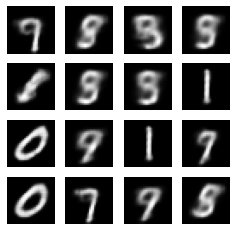

In [49]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait = False)

  print("Epoch : {}, Test set EBLO : {}, time elapse for current epoch : {}".format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

(-0.5, 287.5, 287.5, -0.5)

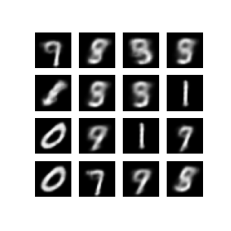

In [51]:
# 마지막 에포크의 이미지 표시
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')

In [52]:
# 모든 저장된 이미지의 애니메이션 표시
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode = "I") as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)



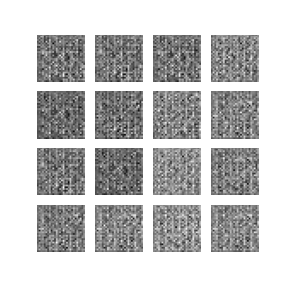

In [53]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [54]:
# 2D 잠재 공간에서 숫자의 2D 형태 표현
def plot_latent_images(model, n, digit_size = 28):

  # 공간 구성
  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size * n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0],(digit_size, digit_size))
      image[i * digit_size : (i+1) * digit_size,
            j * digit_size : (j+1) * digit_size] = digit.numpy()

  plt.figure(figsize = (10, 10))
  plt.imshow(image, cmap = 'Greys_r')
  plt.axis('Off')
  plt.show()

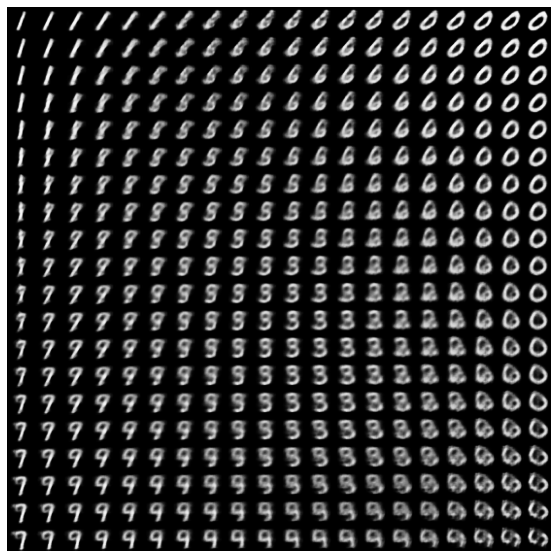

In [55]:
plot_latent_images(model, 20)